# Защита персональных данных клиентов

Нужно защитить данные клиентов страховой компании «Хоть потоп». Разработаем такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию и обоснуем корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

**Описание данных**

Набор данных находится в файле **/datasets/insurance.csv.**

**Признаки:** пол, возраст и зарплата застрахованного, количество членов его семьи.

**Целевой признак:** количество страховых выплат клиенту за последние 5 лет.



## Загрузка данных

Для начала, подготовим необходимые нам далее инструменты

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

Взглянем на имеющиеся данные

In [2]:
df = pd.read_csv('/datasets/insurance.csv')
df.sample(10)

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
714,1,22.0,46400.0,1,0
3752,1,21.0,15100.0,1,0
4802,1,27.0,48400.0,1,0
3490,0,35.0,34400.0,1,0
942,0,35.0,26500.0,0,0
3284,0,18.0,29000.0,0,0
2619,0,32.0,39300.0,1,0
2838,0,27.0,18600.0,0,0
708,0,35.0,28500.0,0,0
1055,1,30.0,37300.0,2,0


Проверим на наличие дубликатов

In [3]:
df.duplicated().sum()

153

В таблице присутствует 153 дубликата. Однако, ввиду задачи защитить персональные данные и малого числа признаков, удалять эти дубликаты из набора данных мы не будем

Посмотрим, как распределены признаки в нашем наборе. Напомню, что признаки в данной задаче столбцы "Пол", "Возраст", "Зарплата" и "Члены семьи". Столбец "Страховые выплаты" - целевой признак

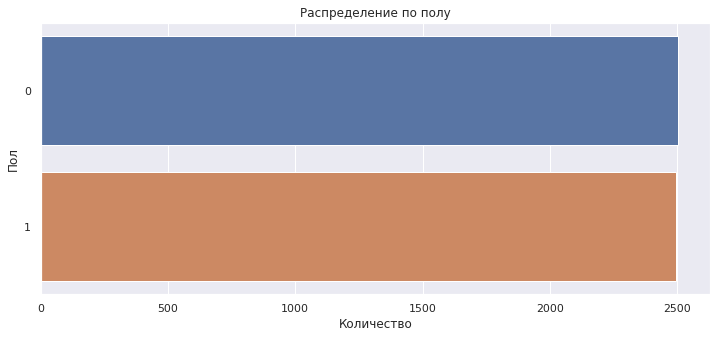

In [4]:
sns.set()
fig, ax = plt.subplots(figsize=(12, 5))
sns.countplot(y='Пол', data=df)
ax.set_title('Распределение по полу')
plt.xlabel('Количество');

Мужчин и женщин примерно одинаковое количество.

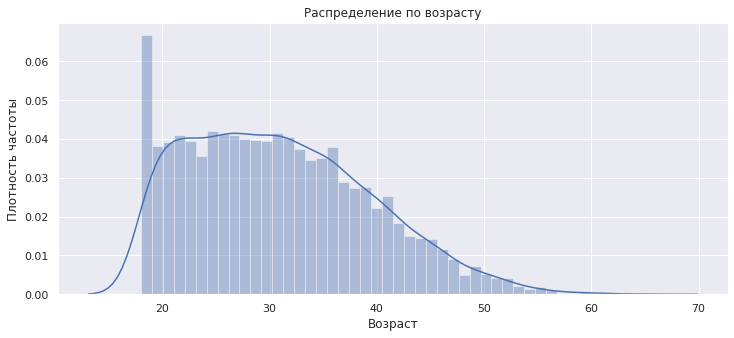

In [5]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.distplot(df['Возраст'], bins=len(df['Возраст'].unique()))
ax.set_title('Распределение по возрасту')
plt.ylabel('Плотность частоты');

Есть выбросы в районе 18ти лет, которые можно объяснить двумя способами: в таблитчных данных застрахованные дети отмечены как 18тилетние, либо молодое поколение серьзнее относится к страховке. В любом случае, дополнительных действий здесь не потребуется

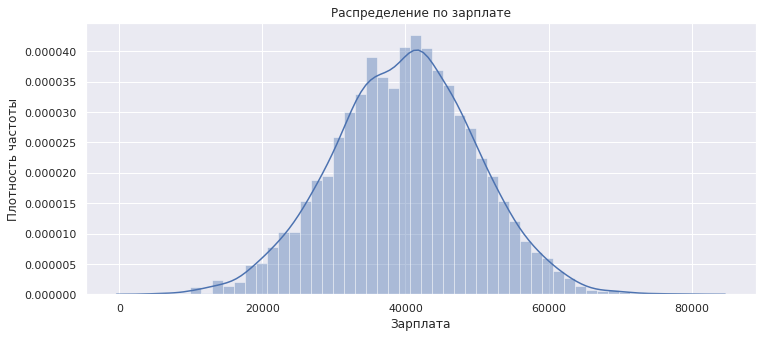

In [6]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.distplot(df['Зарплата'])
ax.set_title('Распределение по зарплате')
plt.ylabel('Плотность частоты');

Данные по зарплате распределены нормально

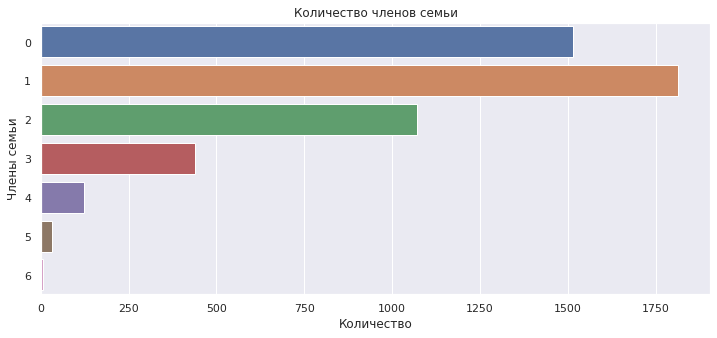

In [7]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.countplot(y='Члены семьи', data=df)
ax.set_title('Количество членов семьи')
plt.xlabel('Количество');

Аномалии отсутствуют, полученные данные соответствуют действительности. 

Проанализировав имеющиеся данные можно сделать вывод, что дополнительной работы и подготовки они не трубеют,а значит можно приступать к следующему этапу.

## Умножение матриц

Опишем, как работает линейная регрессия с помощью формул, которые понадобятся нам для программирования последующего алгоритма.

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

Поделим нашу выборку на две: первая будет содержать только признаки, вторая целеволй признак.

In [8]:
features = df.drop('Страховые выплаты', axis=1).copy()
target = df['Страховые выплаты'].copy()

In [9]:
features.shape

(5000, 4)

In [10]:
target.shape

(5000,)

Данные разделены верно. Далее, создадим класс линейной регрессии, которая будет предсказывать нам, потребуется ли страховая выплата клиенту. Класс будет состоять из двух методов: первый будет вычислять $w$ и $w0$, а второй возвращать предсказания. 

In [11]:
class UserLinearRegression:
    def fit(self, features, target):
        X = np.concatenate((np.ones((features.shape[0], 1)), features), axis=1)
        y = target
        w = np.linalg.inv((X.T @ X)).dot(X.T).dot(y)
        self.w = w[1:]
        self.w0 = w[0]
        
    def predict(self, features):
        return (features @ self.w) + self.w0

Создадим модель и проверим точность её предсказаний

In [12]:
model = UserLinearRegression()
model.fit(features, target)
predictions = model.predict(features)
print('R2 построенной модели {:.3f}'.format(r2_score(target, predictions)))

R2 построенной модели 0.425


R2 больше нуля, хоть и не так близок к еденице, а значит наша модель работает нормально

Для ответа на вопрос "Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии? (Её можно обучить заново.)" построим произвольную матрицу размера 4х4(по количеству столбцов features)

In [13]:
random_matrix = np.random.random((features.shape[1], features.shape[1]))
random_matrix

array([[0.81482008, 0.76564721, 0.11350658, 0.56906399],
       [0.67961419, 0.32679184, 0.67554585, 0.39452473],
       [0.11126881, 0.7292629 , 0.5347645 , 0.87572497],
       [0.35772892, 0.62064514, 0.82342196, 0.32524289]])

Построим обратную матрицу полученной

In [14]:
inverse_random_matrix=np.linalg.inv(random_matrix)
inverse_random_matrix

array([[ 0.63807392,  1.10068866, -0.71489372, -0.52669408],
       [ 1.06588649, -2.24171675, -0.41011667,  1.9585501 ],
       [-0.91985225,  0.69762823, -0.00279333,  0.77071445],
       [-0.40698266,  1.30093553,  1.57597656, -2.03470734]])

Результатом умножения этих матриц должна быть еденичная матрица

In [15]:
print(random_matrix @ inverse_random_matrix)

[[ 1.00000000e+00  8.36716512e-18 -5.07929489e-18  1.10533382e-16]
 [ 2.23303233e-17  1.00000000e+00 -7.74763018e-17  8.39154096e-17]
 [-1.81836861e-16 -9.79662966e-17  1.00000000e+00 -2.37301300e-16]
 [ 1.26336449e-16 -1.47025808e-16 -6.02234839e-17  1.00000000e+00]]


По диагонали еденицы, в остальных ячейках числа достаточно малые и стремящиеся к нулю, значит всё верно и полученная матрица обратима. 

Умножим признаки на обратимую матрицу и заново обучим модель

In [16]:
new_features = features @ random_matrix
model.fit(new_features, target)
predictions = model.predict(new_features)
print('R2 построенной модели {:.3f}'.format(r2_score(target, predictions)))

R2 построенной модели 0.425


**Ответ:** Качество линейной регрессии не меняется

**Обоснование:** 

Предсказания высчитываются по формуле:

$$
a = Xw
$$

Новая матрица признаков получается умножением исходной $Х$ на рандомную $RM$:

$$
a = X RМ w
$$

Подставим полученные выражения в приведенную выше формулу обучения:

$$
w = (X^T X)^{-1} X^T y
$$

Найдем веса $w'$:

$$
w' = ((XRM)^T XRM)^{-1} (XRM)^T y
$$

$$
w' = ((RM^T X^T XRM)^{-1} RM^T X^T y
$$

$(RM^T)^{-1} RM^T$ - это единичная матрица $E$:

$$
w' =  RM^{-1}(X^T X)^{-1} X^T y
$$ 

Таким образом, получаем выражение для новых весов $w'$ через исходные $w$:
$$
w' =  RM^{-1} w
$$ 

## Алгоритм преобразования

**Алгоритм**


Напишем функцию для шифрования личных данных пользователей(преобразования наших признаков с помощью произвольной обратимой матрицы)

In [18]:
def feature_encoding(features):
    random_matrix = np.random.random((features.shape[1], features.shape[1]))
    new_features = features @ random_matrix
    return new_features

In [19]:
encoded_features = feature_encoding(features)
print(encoded_features)

                 0             1             2             3
0     40521.626122  48705.124737  38146.224903  19293.809376
1     31052.740359  37319.551466  29225.159574  14786.990999
2     17162.506123  20624.981506  16150.503798   8173.086308
3     34060.196822  40943.192608  32070.926465  16214.825302
4     21326.430060  25631.266314  20072.733508  10155.511026
...            ...           ...           ...           ...
4995  29165.155117  35055.799968  27456.649760  13885.984902
4996  42803.519493  51451.008100  40299.471695  20378.194791
4997  27691.005455  33285.975010  26072.265686  13183.152155
4998  26713.099198  32109.413263  25149.964546  12718.771262
4999  33165.947421  39865.642866  31224.574700  15790.821574

[5000 rows x 4 columns]


Чтобы вернуть прежние значения признаков нам потребуется обратная операция, умножение новых признаков на обратную матрицу.

In [20]:
def feature_decoding(features):
    random_matrix = np.random.random((features.shape[1], features.shape[1]))
    new_features = features @ np.linalg.inv(random_matrix)
    return new_features

In [21]:
feature_decoding(encoded_features)

,0,1,2,3
0,744170.146934,30953.063413,120040.994406,-808077.536906
1,570265.242691,23719.199876,91976.207411,-619233.539652
2,315178.022536,13109.007976,50830.660566,-342240.800546
3,625532.113071,26018.710458,100916.497145,-679257.008812
4,391641.811249,16289.883920,63169.014126,-425272.137962
...,...,...,...,...
4995,535615.523711,22278.654142,86401.539602,-581614.122221
4996,786107.221771,32697.022738,126814.645402,-853620.492665
4997,508551.825525,21153.086036,82041.707992,-552228.619897
4998,490564.979166,20405.788252,79137.398055,-532695.090107


Данные не совпали с начальной таблицей признаков. Это произошло потому, что в каждой функции мы генерируем разные матрицы. Чтобы избежать этой проблемы обернем весь процесс в класс, который будет создавать общую для обеих функций матрицу-ключ

In [22]:
class crypting:
    def __init__(self, features):
        self.key = np.random.random((features.shape[1], features.shape[1]))
        self.features = features
    
    def feature_encoding(self):
        features = self.features
        new_features = features @ self.key
        return new_features

    def feature_decoding(self):
        old_features = round(abs(self.feature_encoding() @ np.linalg.inv(self.key))).astype(int)
        old_features.columns=self.features.columns
        return old_features

In [23]:
cr = crypting(features)

In [24]:
new_features = cr.feature_encoding()
new_features

,0,1,2,3
0,8347.731800,19307.498733,20604.262755,43800.386259
1,6409.172474,14793.371276,15789.976262,33565.696296
2,3544.976063,8175.722959,8726.624448,18551.540004
3,7006.016903,16229.724699,17319.266845,36815.097437
4,4398.470355,10161.101735,10843.765647,23052.567725
...,...,...,...,...
4995,6007.525560,13895.962193,14830.601840,31524.648007
4996,8810.060678,20395.079049,21764.234429,46265.912155
4997,5698.490507,13194.407323,14080.925722,29930.911931
4998,5500.020054,12728.841608,13584.557882,28874.600359


In [25]:
cr.feature_decoding()

,Пол,Возраст,Зарплата,Члены семьи
0,1,41,49600,1
1,0,46,38000,1
2,0,29,21000,0
3,0,21,41700,2
4,1,28,26100,0
...,...,...,...,...
4995,0,28,35700,2
4996,0,34,52400,1
4997,0,20,33900,2
4998,1,22,32700,3


In [26]:
features

,Пол,Возраст,Зарплата,Члены семьи
0,1,41.0,49600.0,1
1,0,46.0,38000.0,1
2,0,29.0,21000.0,0
3,0,21.0,41700.0,2
4,1,28.0,26100.0,0
...,...,...,...,...
4995,0,28.0,35700.0,2
4996,0,34.0,52400.0,1
4997,0,20.0,33900.0,2
4998,1,22.0,32700.0,3


Данные послу расшифровки совпадают, значит метод работает как надо и мсожет быть применен для шифрования данных пользователей

**Обоснование**


Докажем, что качество линейной регрессии не поменяется.
Предсказания высчитываются по формуле:

$$
a = Xw
$$

Т.к. новая матрица признаков получается умножением исходной $Х$ на рандомную(обозначим $RМ$), то формула будет иметь вид:

$$
a' = X RМ w'
$$

Подставив вычисленное значение весов $w' =  RM^{-1} w$ получаем:

$$
a' = X RМ  RM^{-1} w
$$

$RМ RM^{-1}$ это еденичная матрица $E$, т.е. можно сократить:

$$
a' = X w = a
$$



**Вывод:**

Полученный нами алгоритм прекрасно справляется с поставленной задачей. Кроме того, нам удалось доказать, что качество линейной регрессии после кодировки данных не изменяется, что позволяет нам использовать такое решение для защиты данных клиентов без потери качества на работающей модели.

## Проверка алгоритма

Проверим наш алгоритм, сравнив результаты библиотечной линейной регрессии до его применения и после

In [27]:
model = LinearRegression()
model.fit(features, target)
predictions = model.predict(features)
print('R2 построенной модели {:.3f}'.format(r2_score(target, predictions)))

R2 построенной модели 0.425


In [28]:
model.fit(new_features, target)
predictions = model.predict(new_features)
print('R2 построенной модели {:.3f}'.format(r2_score(target, predictions)))

R2 построенной модели 0.425


Таким образом, мы окончательно убедились в правильности работы алгоритма шифрования. Результаты до преобразования и после не отличаются

## Вывод

- Полученные данные не требуют предподготовки. Имеющиеся выбросы по возрасту, которые объясняются попаданием в категорию 18тилетних лиц младше совершеннолетнего возраста, и дубликаты, которые возникли в следствие малого количества признаков и отсутствия уникального идентификатора клиента.
- При умножении признаков на обратимую матрицу качество регрессии не изменяется. Мы доказали это на практике и с помощью теории
- Был предложен алгоритм, позволяющий зашифровать и дешифровать личные данные клиентов без потери качества модели
- Предложенный алгоритм успешно справился с проверкой с помощью библиотечной линейной регрессии